In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Distance to board: 5.3 [m]

In [2]:
csvs = ['bias_estimation-point-to-point_black_board_small.csv',
        'bias_estimation-point-to-point_white_board_small.csv']

In [3]:
df = pd.read_csv(csvs[1])

In [4]:
print([k for k, _ in df.items()])

['Incidence angle [deg]', ' ICP distance [m]', ' Distance to board error [m]']


In [5]:
# for f in csvs:
#     df = pd.read_csv(f)
    
#     plt.figure()
#     plt.plot(df['Incidence angle [deg]'])
#     plt.show()

In [6]:
# df1 = pd.read_csv(csvs[0])
# half_id = 26
# angles1 = df1['Incidence angle [deg]'][:half_id]
# icp_dists1 = df1[' ICP distance [m]'][:half_id]

# angles2 = df1['Incidence angle [deg]'][half_id:][::-1]
# icp_dists2 = df1[' ICP distance [m]'][half_id:][::-1]

# plt.plot(angles1, icp_dists1)
# plt.plot(angles2, icp_dists2)
# plt.grid()

In [7]:
def interpolate_icp_dists(angles, dists, min_angle=0, max_angle=80, angle_step=1):
    
    angles_uniform = np.arange(min_angle, max_angle, angle_step)
    if angles[0] > angles[-1]:
        angles = angles[::-1]
        dists = dists[::-1]
        
    dists_interp = np.interp(angles_uniform, angles, dists)
    
    if np.min(angles) > min_angle:
        dists_interp[angles_uniform < np.min(angles)] = np.nan
        
    if np.max(angles) < max_angle:
        dists_interp[angles_uniform > np.max(angles)] = np.nan

    return angles_uniform, dists_interp

/tmp/ipykernel_64402/1238224435.py:38: RuntimeWarning: Mean of empty slice
  mean_dists = np.nanmean(all_icp_dists, axis=0)
/home/ruslan/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


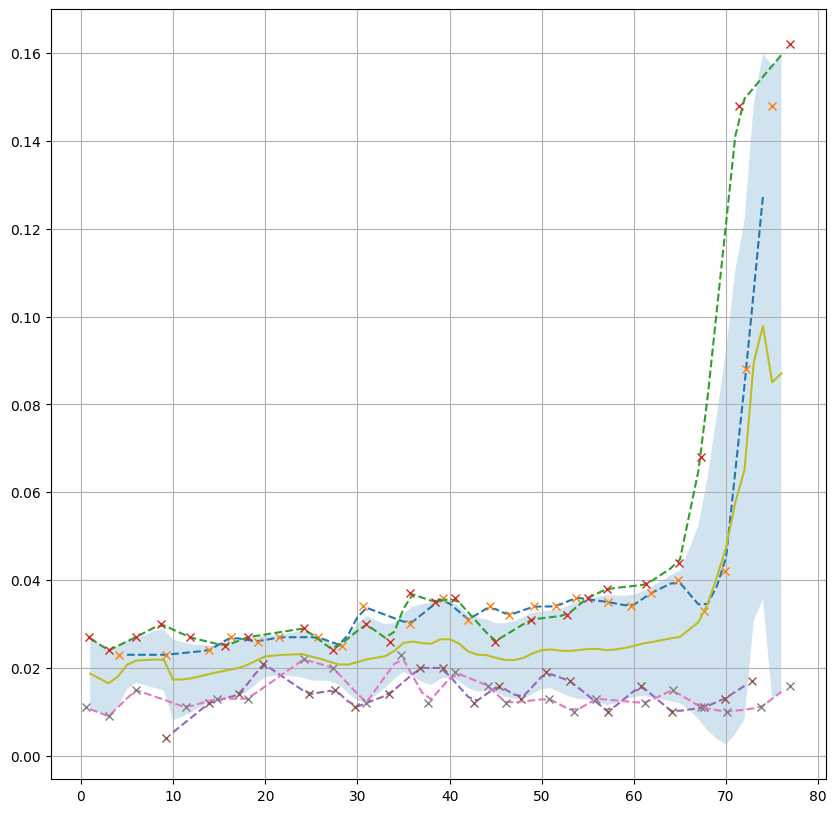

In [8]:
from scipy.signal import argrelextrema

plt.figure(figsize=(10, 10))
plt.grid(visible=True)

all_angles = []
all_icp_dists = []

for f in csvs:
    df = pd.read_csv(f)
    
    angles = np.asarray(df['Incidence angle [deg]'])
    if np.max(angles) < 0:
        angles += 180.
    
    icp_dists = df[' ICP distance [m]']
    icp_dists[icp_dists > 0.20] = np.nan

    minimum_ids = argrelextrema(angles, np.less)[0]
    maximum_ids = argrelextrema(angles, np.greater)[0]

    extremum_ids = np.sort(minimum_ids.tolist() + maximum_ids.tolist()).tolist()   
    ids = [0] + extremum_ids + [len(angles)]

    for i in range(len(ids)-1):
        angles_seq = angles[ids[i]:ids[i+1]]
        dists_seq = icp_dists[ids[i]:ids[i+1]]
        
        angles_interp, dists_interp = interpolate_icp_dists(angles_seq, dists_seq)
        assert len(angles_interp) == len(dists_interp)
        
        plt.plot(angles_interp, dists_interp, '--')
        plt.plot(angles_seq, dists_seq, 'x')
        
        all_angles.append(angles_interp)
        all_icp_dists.append(dists_interp)
        
mean_dists = np.nanmean(all_icp_dists, axis=0)
std_dists = np.nanstd(all_icp_dists, axis=0)

plt.plot(angles_interp, mean_dists)
plt.fill_between(angles_interp, mean_dists - std_dists, mean_dists + std_dists, alpha=0.2)

In [9]:
def mean_bias_estimation(csvs):
    all_angles = []
    all_icp_dists = []

    for f in csvs:
        df = pd.read_csv(f)

        angles = np.asarray(df['Incidence angle [deg]'])
        if np.max(angles) < 0:
            angles += 180.

        icp_dists = df[' ICP distance [m]']
        icp_dists[icp_dists > 0.20] = np.nan

        minimum_ids = argrelextrema(angles, np.less)[0]
        maximum_ids = argrelextrema(angles, np.greater)[0]

        extremum_ids = np.sort(minimum_ids.tolist() + maximum_ids.tolist()).tolist()   
        ids = [0] + extremum_ids + [len(angles)]

        for i in range(len(ids)-1):
            angles_seq = angles[ids[i]:ids[i+1]]
            dists_seq = icp_dists[ids[i]:ids[i+1]]

            angles_interp, dists_interp = interpolate_icp_dists(angles_seq, dists_seq)
            assert len(angles_interp) == len(dists_interp)

            all_angles.append(angles_interp)
            all_icp_dists.append(dists_interp)

    mean_dists = np.nanmean(all_icp_dists, axis=0)
    std_dists = np.nanstd(all_icp_dists, axis=0)

    return mean_dists, std_dists, angles_interp

/tmp/ipykernel_64402/3749081630.py:31: RuntimeWarning: Mean of empty slice
  mean_dists = np.nanmean(all_icp_dists, axis=0)
/home/ruslan/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_64402/3749081630.py:31: RuntimeWarning: Mean of empty slice
  mean_dists = np.nanmean(all_icp_dists, axis=0)
/home/ruslan/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


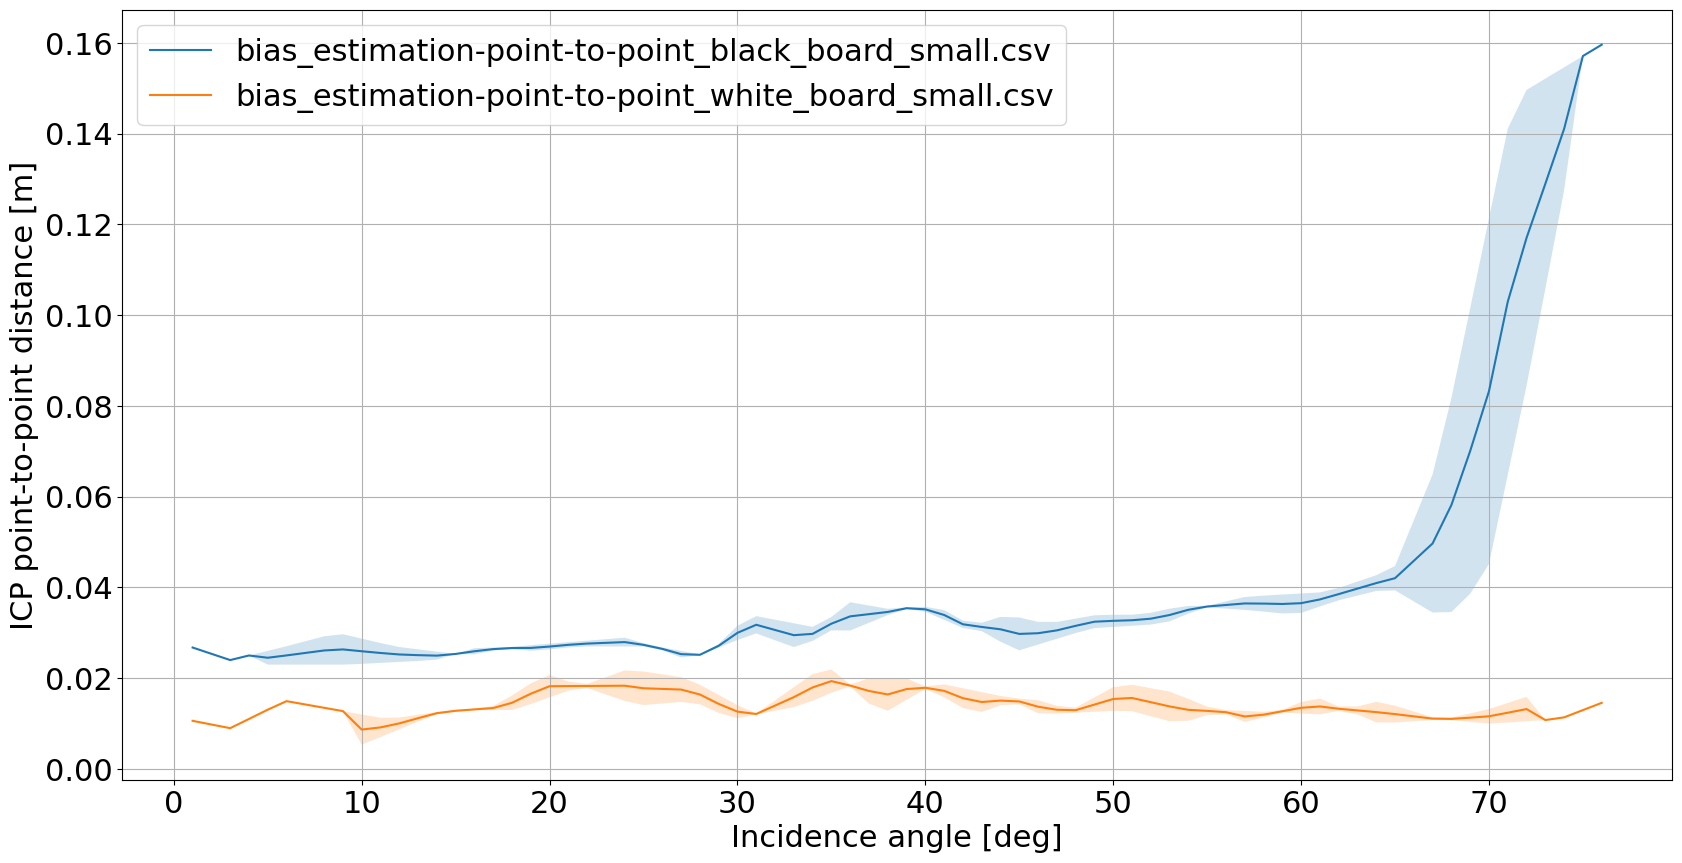

In [10]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.grid()
# plt.ylim([0, 0.20])
# plt.xlim([0, 90])
plt.ylabel('ICP point-to-point distance [m]')
plt.xlabel('Incidence angle [deg]')

for f in csvs:
    mean_dists, std_dists, angles_interp = mean_bias_estimation(csvs=[f])

    plt.plot(angles_interp, mean_dists, label=f)
    plt.fill_between(angles_interp, mean_dists - std_dists, mean_dists + std_dists, alpha=0.2)
    plt.legend()

## Distance to board: 5.3 and 8.6 [m]

In [11]:
csvs = ['bias_estimation-point-to-point_black_board_big.csv',
        'bias_estimation-point-to-point_white_board_big.csv',
        'bias_estimation-point-to-point_black_board_small.csv',
        'bias_estimation-point-to-point_white_board_small.csv']

In [12]:
# for f in csvs:
#     df = pd.read_csv(f)
    
#     plt.figure()
#     plt.plot(df['Incidence angle [deg]'])
#     plt.show()

/tmp/ipykernel_64402/3749081630.py:31: RuntimeWarning: Mean of empty slice
  mean_dists = np.nanmean(all_icp_dists, axis=0)
/home/ruslan/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_64402/3749081630.py:31: RuntimeWarning: Mean of empty slice
  mean_dists = np.nanmean(all_icp_dists, axis=0)
/home/ruslan/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_64402/3749081630.py:31: RuntimeWarning: Mean of empty slice
  mean_dists = np.nanmean(all_icp_dists, axis=0)
/home/ruslan/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_64402/3749081630.py:31: RuntimeWar

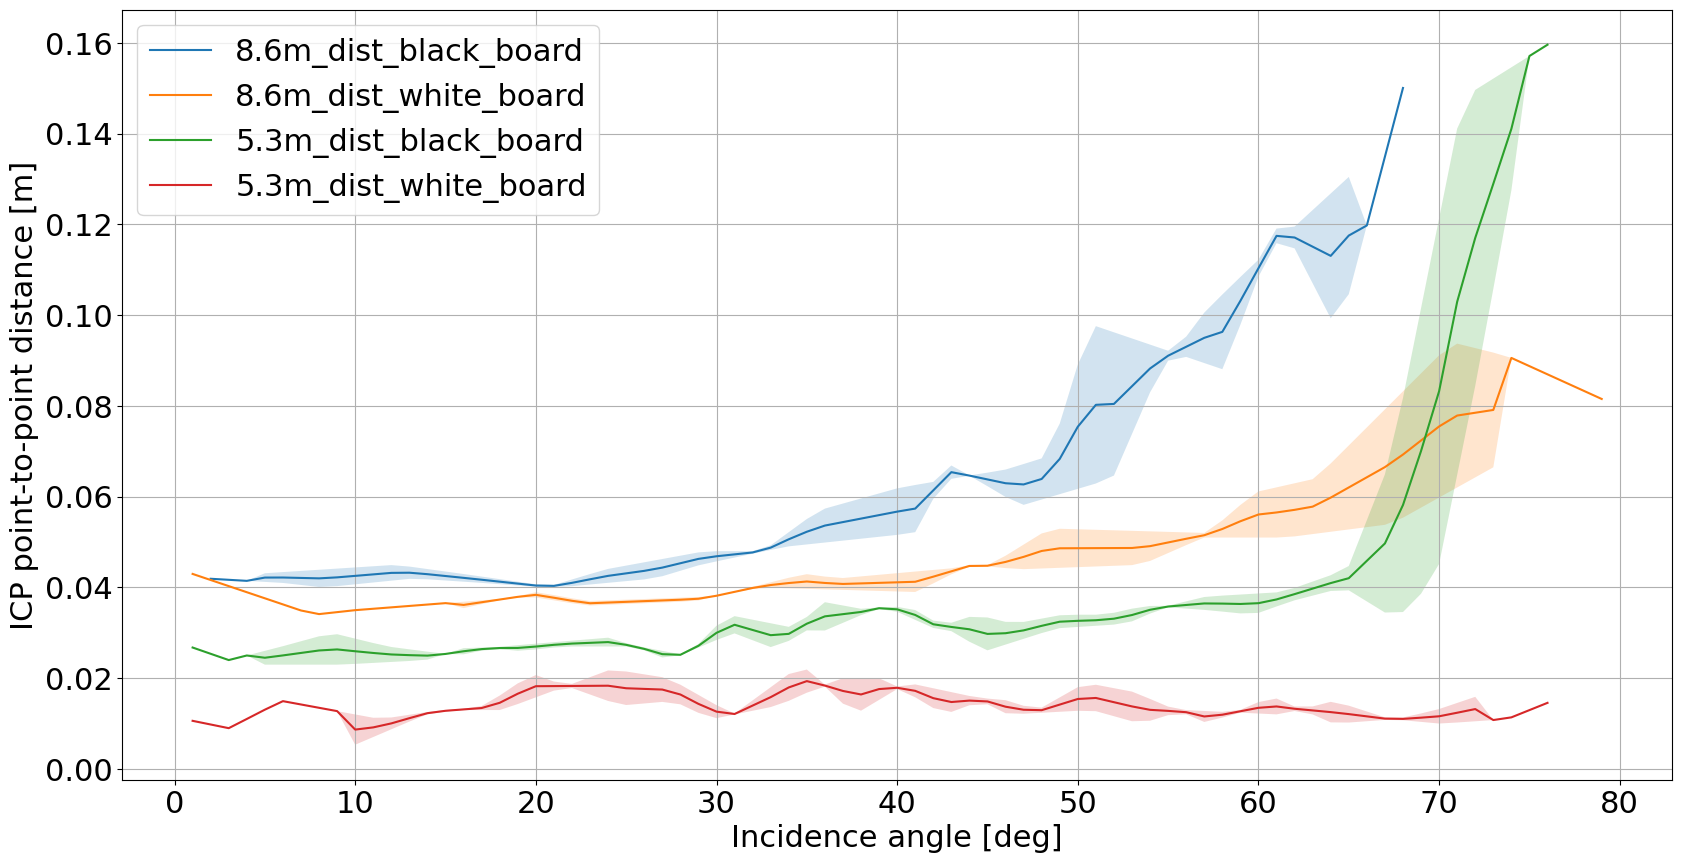

In [13]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.grid()
# plt.ylim([0, 0.20])
# plt.xlim([0, 90])
plt.ylabel('ICP point-to-point distance [m]')
plt.xlabel('Incidence angle [deg]')

def fname2label(fname):
    label_pattern = '{distance}m_dist_{board_side}_board'
    distance = 5.3 if 'small' in fname else 8.6
    board_side = 'white' if 'white' in fname else 'black'
    label = label_pattern.format(distance=distance, board_side=board_side)
    return label

for f in csvs:
    mean_dists, std_dists, angles_interp = mean_bias_estimation(csvs=[f])

    plt.plot(angles_interp, mean_dists, label=fname2label(f))
    plt.fill_between(angles_interp, mean_dists - std_dists, mean_dists + std_dists, alpha=0.2)
    plt.legend()